In [1]:
import numpy as np
import pandas as pd

# --- GRR primitives (binary case) ---
def grr_perturb_binary(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    if np.random.rand() < p:
        return x
    return 1 - x

def grr_matrix(epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    return np.array([[p, q],
                     [q, p]])

# --- Conditional-inferred RR (Cond-RR) for binary two-attribute ---
def cond_rr(df, epsilon, m):
    """
    Implements Cond-RR for binary two-attribute case.
    Args:
      df      : DataFrame with 'X1','X2' columns taking values 0 or 1
      epsilon : total LDP budget
      m       : number of Phase I users
    Returns:
      f1_final, f2_final : dicts {0: estimate, 1: estimate}
    """
    n = len(df)
    idx = np.random.permutation(n)
    idx_a, idx_b = idx[:m], idx[m:]
    nB = n - m

    # Phase I: joint estimation with SPL at epsilon/2
    eps1 = epsilon / 2
    # perturb both bits
    y_a = np.zeros((m,2), dtype=int)
    for i, ui in enumerate(idx_a):
        y_a[i,0] = grr_perturb_binary(df.iloc[ui]['X1'], eps1)
        y_a[i,1] = grr_perturb_binary(df.iloc[ui]['X2'], eps1)
    # empirical distribution of y pairs
    counts_y = np.zeros(4)
    for pair in y_a:
        counts_y[pair[0]*2 + pair[1]] += 1
    Yhat = counts_y / m
    # build channel matrix M_A = M(eps1) ⊗ M(eps1)
    M1 = grr_matrix(eps1)
    M_A = np.kron(M1, M1)  # 4x4
    P_hat = np.linalg.solve(M_A, Yhat)  # joint estimate [P00,P01,P10,P11]
    # ensure non-negative
    P_hat = np.clip(P_hat, 0, None)
    P_hat = P_hat / P_hat.sum()

    # marginal SPL estimates
    f1_spl = {v: P_hat[v*2 + 0] + P_hat[v*2 + 1] for v in [0,1]}
    f2_spl = {v: P_hat[0*2 + v] + P_hat[1*2 + v] for v in [0,1]}

    # Phase II: conditional perturbation
    eps2 = epsilon
    Y1_b = np.zeros(nB, dtype=int)
    Y2_b = np.zeros(nB, dtype=int)
    J = np.random.randint(1,3, size=nB)  # 1 or 2
    # compute conditional tables
    # Pr(X2=w | X1=v)
    cond21 = {
        v: [P_hat[v*2 + w] / (P_hat[v*2+0] + P_hat[v*2+1]) 
            if P_hat[v*2+0]+P_hat[v*2+1]>0 else 0.5
            for w in [0,1]]
        for v in [0,1]
    }
    # Pr(X1=w | X2=v)
    cond12 = {
        v: [P_hat[w*2 + v] / (P_hat[0*2+v] + P_hat[1*2+v]) 
            if P_hat[0*2+v]+P_hat[1*2+v]>0 else 0.5
            for w in [0,1]]
        for v in [0,1]
    }
    # generate Y_b
    for i, ui in enumerate(idx_b):
        x1, x2 = df.iloc[ui]['X1'], df.iloc[ui]['X2']
        if J[i] == 1:
            y1 = grr_perturb_binary(x1, eps2)
            y2 = np.random.choice([0,1], p=cond21[y1])
        else:
            y2 = grr_perturb_binary(x2, eps2)
            y1 = np.random.choice([0,1], p=cond12[y2])
        Y1_b[i], Y2_b[i] = y1, y2

    # separate direct and synthetic
    idx_dir1 = (J == 1)
    idx_dir2 = (J == 2)
    n1 = idx_dir1.sum()
    n2 = idx_dir2.sum()
    p = np.exp(epsilon)/(np.exp(epsilon)+1)
    q = 1-p

    # f_RR_1 using only direct
    counts_rr1 = np.bincount(Y1_b[idx_dir1], minlength=2)
    f_rr1 = {v: (counts_rr1[v] - n1*q) / (n1*(p-q)) if n1>0 else 0.5 for v in [0,1]}
    # f_SYN_1 using synthetic (when J=2)
    counts_syn1 = np.bincount(Y1_b[idx_dir2], minlength=2)
    f_syn1 = {v: counts_syn1[v]/n2 if n2>0 else 0.5 for v in [0,1]}
    # mixture f_star_1
    f_star1 = {v: (n1/nB)*f_rr1[v] + (n2/nB)*f_syn1[v] for v in [0,1]}

    # same for attribute 2
    counts_rr2 = np.bincount(Y2_b[idx_dir2], minlength=2)
    f_rr2 = {v: (counts_rr2[v] - n2*q) / (n2*(p-q)) if n2>0 else 0.5 for v in [0,1]}
    counts_syn2 = np.bincount(Y2_b[idx_dir1], minlength=2)
    f_syn2 = {v: counts_syn2[v]/n1 if n1>0 else 0.5 for v in [0,1]}
    f_star2 = {v: (n2/nB)*f_rr2[v] + (n1/nB)*f_syn2[v] for v in [0,1]}

    # combine Phase I + Phase II
    f1_final = {v: (m*f1_spl[v] + nB*f_star1[v]) / n for v in [0,1]}
    f2_final = {v: (m*f2_spl[v] + nB*f_star2[v]) / n for v in [0,1]}

    return f1_final, f2_final

# Example usage:
if __name__ == "__main__":
    # synthetic binary dataset
    n = 10000
    df = pd.DataFrame({
        'X1': np.random.binomial(1, 0.4, size=n),
        'X2': np.random.binomial(1, 0.6, size=n)
    })
    epsilon = 1.0
    m = int(0.2 * n)
    f1, f2 = cond_rr(df, epsilon, m)
    print("Cond-RR estimates X1:", f1)
    print("Cond-RR estimates X2:", f2)


Cond-RR estimates X1: {0: 0.6107883496935946, 1: 0.3892116503064052}
Cond-RR estimates X2: {0: 0.36860624604404735, 1: 0.6313937539559527}


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
np.random.seed(0)
n = 5000
m = int(n * 0.2)   # SPL users (Phase I)
n_B = n - m        # Phase II users
epsilons = np.linspace(0.1, 4, 15)

# Generate perfectly correlated data: X1 = X2
X = np.random.binomial(1, 0.7, n)
data = np.vstack([X, X]).T

def M(alpha):
    expa = np.exp(alpha)
    p = expa / (expa + 1)
    q = 1 - p
    return np.array([[p, q],[q, p]])

def grr(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    if np.random.rand() < p:
        return x
    return 1-x

def split_budget_perturb(x_row, epsilon):
    # Applies RR with epsilon/2 to both bits
    p = np.exp(epsilon/2) / (np.exp(epsilon/2) + 1)
    out = []
    for v in x_row:
        if np.random.rand() < p:
            out.append(v)
        else:
            out.append(1-v)
    return tuple(out)

def estimate_joint_distribution(Y):
    # Y: list of privatized pairs (tuples)
    # Estimate empirical distribution
    counts = np.zeros(4)
    for a, b in Y:
        idx = 2*a + b
        counts[idx] += 1
    Y_emp = counts / len(Y)
    # Build channel matrix
    p = np.exp(epsilon/2) / (np.exp(epsilon/2) + 1)
    q = 1 - p
    M_A = np.kron(M(epsilon/2), M(epsilon/2))  # 4x4
    # Invert to get estimate of P
    P_hat = np.linalg.solve(M_A, Y_emp)
    return P_hat.reshape(2,2)  # rows: X1, cols: X2

def conditional_sampler(P_hat, given_val, given_idx):
    if given_idx == 0:
        joint = P_hat[given_val, :]
        marginal = np.sum(joint)
    else:
        joint = P_hat[:, given_val]
        marginal = np.sum(joint)
    if marginal > 0:
        cond = joint / marginal
    else:
        cond = np.ones(2) / 2
    # Fix: clip negatives, renormalize
    cond = np.clip(cond, 0, None)
    cond = cond / cond.sum() if cond.sum() > 0 else np.ones(2) / 2
    return cond
Swap this in and yo

def cond_rr_sim(data, epsilon):
    # Split
    idx = np.arange(len(data))
    np.random.shuffle(idx)
    idx_SPL = idx[:m]
    idx_B = idx[m:]
    # Phase I: Joint dist estimation
    Y_SPL = [split_budget_perturb(data[i], epsilon) for i in idx_SPL]
    P_hat = estimate_joint_distribution(Y_SPL)
    # Phase II: Conditional perturbation
    # Store (Y1, Y2) per user
    Y_out = []
    J_choices = []
    for i in idx_B:
        J = np.random.choice([0,1])  # 0: X1, 1: X2
        J_choices.append(J)
        # Direct RR for chosen attr
        yj = grr(data[i][J], epsilon)
        # Synthetic for other attr
        cond = conditional_sampler(P_hat, yj, J)
        y_other = np.random.choice([0,1], p=cond)
        y_pair = [None, None]
        y_pair[J] = yj
        y_pair[1-J] = y_other
        Y_out.append(tuple(y_pair))
    Y_out = np.array(Y_out)
    # Estimate frequencies for X1, X2
    results = []
    for j in range(2):
        # Combine SPL and Phase II
        # SPL
        vals_SPL = [data[i][j] for i in idx_SPL]
        f_SPL = np.mean(vals_SPL)
        # Phase II: estimate
        # If j chosen as J, use RR estimator, else sample mean
        idx_chosen = [i for i,x in enumerate(J_choices) if x == j]
        idx_syn = [i for i,x in enumerate(J_choices) if x != j]
        # RR estimator
        I_RR = np.sum(Y_out[idx_chosen, j])
        n_RR = len(idx_chosen)
        if n_RR > 0:
            p = np.exp(epsilon) / (np.exp(epsilon) + 1)
            q = 1 - p
            f_RR = (I_RR - n_RR*q) / (n_RR * (p - q))
        else:
            f_RR = 0.5
        # Synthetic
        if len(idx_syn) > 0:
            f_syn = np.mean(Y_out[idx_syn, j])
        else:
            f_syn = 0.5
        # Mix
        f_hat = (m * f_SPL + n_RR * f_RR + len(idx_syn) * f_syn) / n
        results.append(f_hat)
    return results

def grr_baseline(data, epsilon):
    # Apply GRR to both attributes independently
    n = len(data)
    Y = []
    for x1, x2 in data:
        y1 = grr(x1, epsilon)
        y2 = grr(x2, epsilon)
        Y.append((y1, y2))
    Y = np.array(Y)
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    # Unbiased estimator for each attr
    f1 = (np.sum(Y[:,0]) - n*q) / (n*(p-q))
    f2 = (np.sum(Y[:,1]) - n*q) / (n*(p-q))
    return [f1, f2]

# Run simulation for different epsilons
mse_condrr = []
mse_grr = []
true_freqs = [np.mean(data[:,0]), np.mean(data[:,1])]
for epsilon in epsilons:
    # Cond-RR
    est_condrr = cond_rr_sim(data, epsilon)
    mse_condrr.append(np.mean((np.array(est_condrr) - true_freqs)**2))
    # GRR
    est_grr = grr_baseline(data, epsilon)
    mse_grr.append(np.mean((np.array(est_grr) - true_freqs)**2))

# Plot
plt.plot(epsilons, mse_grr, label="Attribute-wise GRR", marker='o')
plt.plot(epsilons, mse_condrr, label="Cond-RR (correlation-aware)", marker='s')
plt.yscale('log')
plt.xlabel(r"Privacy budget $\epsilon$")
plt.ylabel("MSE (log scale)")
plt.title("MSE of Marginal Estimation vs. $\epsilon$ (Two Correlated Binary Attributes)")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


SyntaxError: invalid syntax (3270023481.py, line 69)

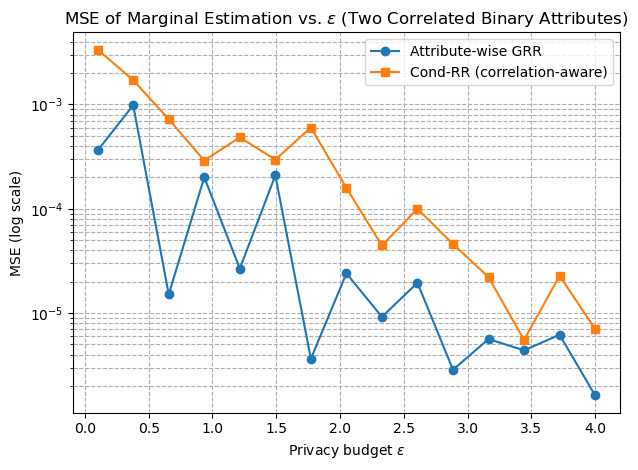

In [6]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
np.random.seed(0)
n = 5000
m = int(n * 015)   # SPL users (Phase I)
n_B = n - m        # Phase II users
epsilons = np.linspace(0.1, 4, 15)

# Generate perfectly correlated data: X1 = X2 (feel free to adjust correlation)
X = np.random.binomial(1, 0.7, n)
data = np.vstack([X, X]).T

def M(alpha):
    expa = np.exp(alpha)
    p = expa / (expa + 1)
    q = 1 - p
    return np.array([[p, q],[q, p]])

def grr(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    if np.random.rand() < p:
        return x
    return 1-x

def split_budget_perturb(x_row, epsilon):
    # Applies RR with epsilon/2 to both bits
    p = np.exp(epsilon/2) / (np.exp(epsilon/2) + 1)
    out = []
    for v in x_row:
        if np.random.rand() < p:
            out.append(v)
        else:
            out.append(1-v)
    return tuple(out)

def estimate_joint_distribution(Y):
    # Y: list of privatized pairs (tuples)
    # Estimate empirical distribution
    counts = np.zeros(4)
    for a, b in Y:
        idx = 2*a + b
        counts[idx] += 1
    Y_emp = counts / len(Y)
    # Build channel matrix
    p = np.exp(epsilon/2) / (np.exp(epsilon/2) + 1)
    q = 1 - p
    M_A = np.kron(M(epsilon/2), M(epsilon/2))  # 4x4
    # Invert to get estimate of P
    P_hat = np.linalg.solve(M_A, Y_emp)
    return P_hat.reshape(2,2)  # rows: X1, cols: X2

def conditional_sampler(P_hat, given_val, given_idx):
    # Returns P(X_{other} | X_{given}=given_val)
    # P_hat: 2x2 array for joint
    # given_idx: 0 for X1, 1 for X2
    # returns prob for [0,1]
    if given_idx == 0:
        joint = P_hat[given_val, :]
        marginal = np.sum(joint)
    else:
        joint = P_hat[:, given_val]
        marginal = np.sum(joint)
    if marginal > 0:
        cond = joint / marginal
    else:
        cond = np.ones(2) / 2
    # Fix: clip negatives, renormalize
    cond = np.clip(cond, 0, None)
    cond = cond / cond.sum() if cond.sum() > 0 else np.ones(2) / 2
    return cond

def cond_rr_sim(data, epsilon):
    # Split
    idx = np.arange(len(data))
    np.random.shuffle(idx)
    idx_SPL = idx[:m]
    idx_B = idx[m:]
    # Phase I: Joint dist estimation
    Y_SPL = [split_budget_perturb(data[i], epsilon) for i in idx_SPL]
    P_hat = estimate_joint_distribution(Y_SPL)
    # Phase II: Conditional perturbation
    # Store (Y1, Y2) per user
    Y_out = []
    J_choices = []
    for i in idx_B:
        J = np.random.choice([0,1])  # 0: X1, 1: X2
        J_choices.append(J)
        # Direct RR for chosen attr
        yj = grr(data[i][J], epsilon)
        # Synthetic for other attr
        cond = conditional_sampler(P_hat, yj, J)
        y_other = np.random.choice([0,1], p=cond)
        y_pair = [None, None]
        y_pair[J] = yj
        y_pair[1-J] = y_other
        Y_out.append(tuple(y_pair))
    Y_out = np.array(Y_out)
    # Estimate frequencies for X1, X2
    results = []
    for j in range(2):
        # Combine SPL and Phase II
        # SPL
        vals_SPL = [data[i][j] for i in idx_SPL]
        f_SPL = np.mean(vals_SPL)
        # Phase II: estimate
        # If j chosen as J, use RR estimator, else sample mean
        idx_chosen = [i for i,x in enumerate(J_choices) if x == j]
        idx_syn = [i for i,x in enumerate(J_choices) if x != j]
        # RR estimator
        if len(idx_chosen) > 0:
            I_RR = np.sum(Y_out[idx_chosen, j])
            n_RR = len(idx_chosen)
            p = np.exp(epsilon) / (np.exp(epsilon) + 1)
            q = 1 - p
            f_RR = (I_RR - n_RR*q) / (n_RR * (p - q))
        else:
            f_RR = 0.5
        # Synthetic
        if len(idx_syn) > 0:
            f_syn = np.mean(Y_out[idx_syn, j])
        else:
            f_syn = 0.5
        # Mix
        f_hat = (m * f_SPL + len(idx_chosen) * f_RR + len(idx_syn) * f_syn) / n
        results.append(f_hat)
    return results

def grr_baseline(data, epsilon):
    # Apply GRR to both attributes independently
    n = len(data)
    Y = []
    for x1, x2 in data:
        y1 = grr(x1, epsilon)
        y2 = grr(x2, epsilon)
        Y.append((y1, y2))
    Y = np.array(Y)
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    # Unbiased estimator for each attr
    f1 = (np.sum(Y[:,0]) - n*q) / (n*(p-q))
    f2 = (np.sum(Y[:,1]) - n*q) / (n*(p-q))
    return [f1, f2]

# Run simulation for different epsilons
mse_condrr = []
mse_grr = []
true_freqs = [np.mean(data[:,0]), np.mean(data[:,1])]
for epsilon in epsilons:
    # Cond-RR
    est_condrr = cond_rr_sim(data, epsilon)
    mse_condrr.append(np.mean((np.array(est_condrr) - true_freqs)**2))
    # GRR
    est_grr = grr_baseline(data, epsilon)
    mse_grr.append(np.mean((np.array(est_grr) - true_freqs)**2))

# Plot
plt.plot(epsilons, mse_grr, label="Attribute-wise GRR", marker='o')
plt.plot(epsilons, mse_condrr, label="Cond-RR (correlation-aware)", marker='s')
plt.yscale('log')
plt.xlabel(r"Privacy budget $\epsilon$")
plt.ylabel("MSE (log scale)")
plt.title("MSE of Marginal Estimation vs. $\epsilon$ (Two Correlated Binary Attributes)")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


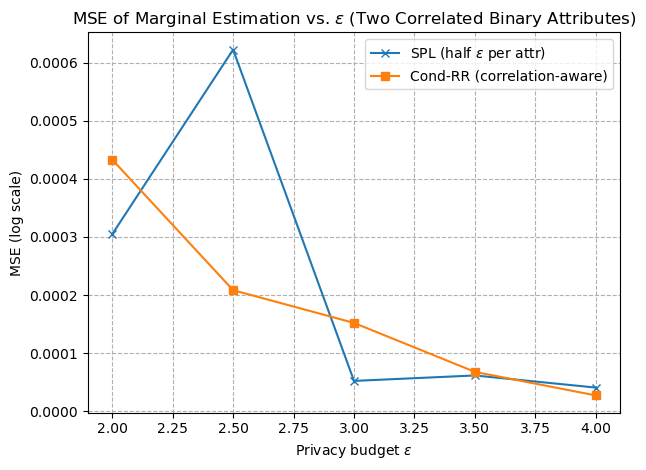

In [30]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
#np.random.seed(0)
n = 5000
m = int(n * 0.5)   # SPL users (Phase I)
n_B = n - m        # Phase II users
epsilons = np.linspace(2, 4, 5)

# Generate perfectly correlated data: X1 = X2 (can adjust to partial if desired)
X = np.random.binomial(1, 0.9, n)
data = np.vstack([X, X]).T

def M(alpha):
    expa = np.exp(alpha)
    p = expa / (expa + 1)
    q = 1 - p
    return np.array([[p, q],[q, p]])

def grr(x, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    if np.random.rand() < p:
        return x
    return 1-x

def split_budget_perturb(x_row, epsilon):
    # Applies RR with epsilon/2 to both bits
    p = np.exp(epsilon/2) / (np.exp(epsilon/2) + 1)
    out = []
    for v in x_row:
        if np.random.rand() < p:
            out.append(v)
        else:
            out.append(1-v)
    return tuple(out)

def estimate_joint_distribution(Y):
    # Y: list of privatized pairs (tuples)
    # Estimate empirical distribution
    counts = np.zeros(4)
    for a, b in Y:
        idx = 2*a + b
        counts[idx] += 1
    Y_emp = counts / len(Y)
    # Build channel matrix
    p = np.exp(epsilon/2) / (np.exp(epsilon/2) + 1)
    q = 1 - p
    M_A = np.kron(M(epsilon/2), M(epsilon/2))  # 4x4
    # Invert to get estimate of P
    P_hat = np.linalg.solve(M_A, Y_emp)
    return P_hat.reshape(2,2)  # rows: X1, cols: X2

def conditional_sampler(P_hat, given_val, given_idx):
    if given_idx == 0:
        joint = P_hat[given_val, :]
        marginal = np.sum(joint)
    else:
        joint = P_hat[:, given_val]
        marginal = np.sum(joint)
    if marginal > 0:
        cond = joint / marginal
    else:
        cond = np.ones(2) / 2
    # Fix: clip negatives, renormalize
    cond = np.clip(cond, 0, None)
    cond = cond / cond.sum() if cond.sum() > 0 else np.ones(2) / 2
    return cond

def cond_rr_sim(data, epsilon):
    idx = np.arange(len(data))
    np.random.shuffle(idx)
    idx_SPL = idx[:m]
    idx_B = idx[m:]
    # Phase I: Joint dist estimation
    Y_SPL = [split_budget_perturb(data[i], epsilon) for i in idx_SPL]
    P_hat = estimate_joint_distribution(Y_SPL)
    # Phase II: Conditional perturbation
    Y_out = []
    J_choices = []
    for i in idx_B:
        J = np.random.choice([0,1])  # 0: X1, 1: X2
        J_choices.append(J)
        # Direct RR for chosen attr
        yj = grr(data[i][J], epsilon)
        # Synthetic for other attr
        cond = conditional_sampler(P_hat, yj, J)
        y_other = np.random.choice([0,1], p=cond)
        y_pair = [None, None]
        y_pair[J] = yj
        y_pair[1-J] = y_other
        Y_out.append(tuple(y_pair))
    Y_out = np.array(Y_out)
    results = []
    for j in range(2):
        vals_SPL = [data[i][j] for i in idx_SPL]
        f_SPL = np.mean(vals_SPL)
        idx_chosen = [i for i,x in enumerate(J_choices) if x == j]
        idx_syn = [i for i,x in enumerate(J_choices) if x != j]
        if len(idx_chosen) > 0:
            I_RR = np.sum(Y_out[idx_chosen, j])
            n_RR = len(idx_chosen)
            p = np.exp(epsilon) / (np.exp(epsilon) + 1)
            q = 1 - p
            f_RR = (I_RR - n_RR*q) / (n_RR * (p - q))
        else:
            f_RR = 0.5
        if len(idx_syn) > 0:
            f_syn = np.mean(Y_out[idx_syn, j])
        else:
            f_syn = 0.5
        f_hat = (m * f_SPL + len(idx_chosen) * f_RR + len(idx_syn) * f_syn) / n
        results.append(f_hat)
    return results

def grr_baseline(data, epsilon):
    n = len(data)
    Y = []
    for x1, x2 in data:
        y1 = grr(x1, epsilon)
        y2 = grr(x2, epsilon)
        Y.append((y1, y2))
    Y = np.array(Y)
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    f1 = (np.sum(Y[:,0]) - n*q) / (n*(p-q))
    f2 = (np.sum(Y[:,1]) - n*q) / (n*(p-q))
    return [f1, f2]

def spl_baseline(data, epsilon):
    n = len(data)
    Y = []
    for x1, x2 in data:
        y1 = grr(x1, epsilon/2)
        y2 = grr(x2, epsilon/2)
        Y.append((y1, y2))
    Y = np.array(Y)
    p = np.exp(epsilon/2) / (np.exp(epsilon/2) + 1)
    q = 1 - p
    f1 = (np.sum(Y[:,0]) - n*q) / (n*(p-q))
    f2 = (np.sum(Y[:,1]) - n*q) / (n*(p-q))
    return [f1, f2]

# Run simulation for different epsilons
mse_condrr = []
mse_grr = []
mse_spl = []
true_freqs = [np.mean(data[:,0]), np.mean(data[:,1])]
for epsilon in epsilons:
    est_condrr = cond_rr_sim(data, epsilon)
    mse_condrr.append(np.mean((np.array(est_condrr) - true_freqs)**2))
    est_grr = grr_baseline(data, epsilon)
    mse_grr.append(np.mean((np.array(est_grr) - true_freqs)**2))
    est_spl = spl_baseline(data, epsilon)
    mse_spl.append(np.mean((np.array(est_spl) - true_freqs)**2))

# Plot
#plt.plot(epsilons, mse_grr, label="GRR (full $\epsilon$ per attr)", marker='o')
plt.plot(epsilons, mse_spl, label="SPL (half $\epsilon$ per attr)", marker='x')
plt.plot(epsilons, mse_condrr, label="Cond-RR (correlation-aware)", marker='s')
#plt.yscale('log')
plt.xlabel(r"Privacy budget $\epsilon$")
plt.ylabel("MSE (log scale)")
plt.title("MSE of Marginal Estimation vs. $\epsilon$ (Two Correlated Binary Attributes)")
plt.legend()
plt.grid(True, which='both', ls='--')
plt.tight_layout()
plt.show()


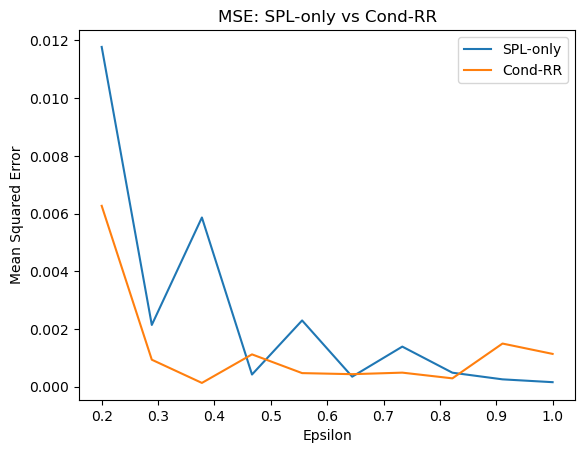

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
#np.random.seed(0)

def generate_data(n, p00=0.4, p01=0.1, p10=0.1, p11=0.4):
    """Generate correlated binary data with specified joint probabilities."""
    probs = [p00, p01, p10, p11]
    outcomes = [(0,0), (0,1), (1,0), (1,1)]
    idx = np.random.choice(4, size=n, p=probs)
    data = np.array([outcomes[i] for i in idx])
    return data

def grr_perturb(bit, epsilon):
    """Binary GRR perturbation."""
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    return bit if np.random.rand() < p else 1 - bit

def rr_estimate(reports, epsilon):
    """Estimate true frequency under RR for binary domain."""
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    n = len(reports)
    count1 = np.sum(reports)
    return (count1 - n * q) / (n * (p - q))

def spl_estimate(data, epsilon):
    """SPL: Split-budget LDP (each attribute with epsilon/2)."""
    eps_half = epsilon / 2
    reports = np.array([[grr_perturb(x, eps_half) for x in pair] for pair in data])
    f1 = rr_estimate(reports[:,0], eps_half)
    f2 = rr_estimate(reports[:,1], eps_half)
    return np.array([f1, f2])

def cond_rr_estimate(data, epsilon, m):
    """Cond-RR: Two-phase conditional RR with m SPL users."""
    n = len(data)
    eps_half = epsilon / 2

    # Phase I: SPL on first m users to estimate joint distribution
    spl_reports = np.array([[grr_perturb(x, eps_half) for x in pair] for pair in data[:m]])
    counts = {k:0 for k in [(0,0),(0,1),(1,0),(1,1)]}
    for r in spl_reports:
        counts[tuple(r)] += 1
    Y_hat = np.array([counts[k]/m for k in [(0,0),(0,1),(1,0),(1,1)]])
    
    p = np.exp(eps_half) / (np.exp(eps_half) + 1)
    q = 1 - p
    M = np.array([[p*p, p*q, q*p, q*q],
                  [p*q, p*p, q*q, q*p],
                  [q*p, q*q, p*p, p*q],
                  [q*q, q*p, p*q, p*p]])
    P_hat = np.linalg.inv(M).dot(Y_hat)
    P_hat = np.clip(P_hat, 0, None)
    P_hat = P_hat / np.sum(P_hat)
    P00, P01, P10, P11 = P_hat
    cond_2_given_1 = {0: P00/(P00+P01) if P00+P01>0 else 0.5,
                      1: P10/(P10+P11) if P10+P11>0 else 0.5}
    cond_1_given_2 = {0: P00/(P00+P10) if P00+P10>0 else 0.5,
                      1: P01/(P01+P11) if P01+P11>0 else 0.5}

    # SPL marginal estimates from Phase I
    f1_spl = rr_estimate(spl_reports[:,0], eps_half)
    f2_spl = rr_estimate(spl_reports[:,1], eps_half)

    # Phase II: conditional perturbation for remaining users
    f_rr_reports = {1: [], 2: []}
    syn_reports = {1: [], 2: []}
    for x1, x2 in data[m:]:
        j = np.random.choice([1,2])
        if j == 1:
            y1 = grr_perturb(x1, epsilon)
            y2 = np.random.choice([0,1], p=[cond_2_given_1[y1], 1-cond_2_given_1[y1]])
            f_rr_reports[1].append(y1)
            syn_reports[2].append(y2)
        else:
            y2 = grr_perturb(x2, epsilon)
            y1 = np.random.choice([0,1], p=[cond_1_given_2[y2], 1-cond_1_given_2[y2]])
            f_rr_reports[2].append(y2)
            syn_reports[1].append(y1)

    # Combine estimates
    est = {}
    for j in [1,2]:
        n_rr = len(f_rr_reports[j])
        n_syn = len(syn_reports[j])
        f_rr_hat = rr_estimate(f_rr_reports[j], epsilon) if n_rr > 0 else 0
        f_syn_hat = np.mean(syn_reports[j]) if n_syn > 0 else 0
        f_spl = f1_spl if j == 1 else f2_spl
        est[j] = (m * f_spl + n_rr * f_rr_hat + n_syn * f_syn_hat) / n

    return np.array([est[1], est[2]])

# Simulation parameters
n = 10000
m = int(0.2 * n)
epsilons = np.linspace(0.2, 1.0, 10)
mse_spl = []
mse_cond = []

for eps in epsilons:
    data = generate_data(n)
    true_freq = data.mean(axis=0)
    est_spl = spl_estimate(data, eps)
    est_cond = cond_rr_estimate(data, eps, m)
    mse_spl.append(np.mean((est_spl - true_freq)**2))
    mse_cond.append(np.mean((est_cond - true_freq)**2))

# Plot the MSE curves
plt.figure()
plt.plot(epsilons, mse_spl, label='SPL-only')
plt.plot(epsilons, mse_cond, label='Cond-RR')
plt.xlabel('Epsilon')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('MSE: SPL-only vs Cond-RR')
plt.show()


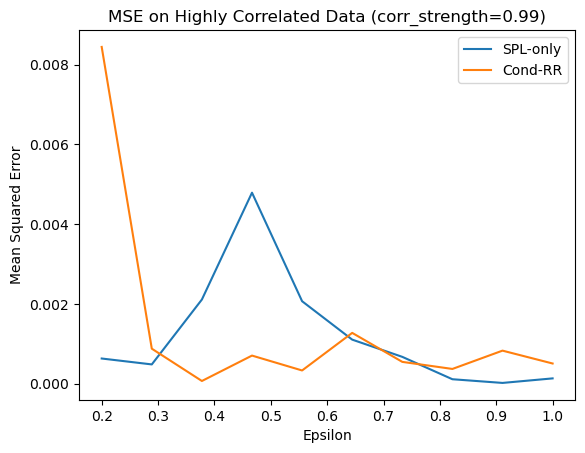

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility
#np.random.seed(0)

def generate_high_corr_data(n, corr_strength=0.99):
    """Generate highly correlated binary data."""
    # Probability of matching bits
    p_match = corr_strength
    p00 = p_match / 2
    p11 = p_match / 2
    # Remaining probability for mismatches
    p_mismatch = 1 - p_match
    p01 = p_mismatch / 2
    p10 = p_mismatch / 2
    probs = [p00, p01, p10, p11]
    outcomes = [(0,0), (0,1), (1,0), (1,1)]
    idx = np.random.choice(4, size=n, p=probs)
    data = np.array([outcomes[i] for i in idx])
    return data

def grr_perturb(bit, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    return bit if np.random.rand() < p else 1 - bit

def rr_estimate(reports, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    n = len(reports)
    count1 = np.sum(reports)
    return (count1 - n * q) / (n * (p - q))

def spl_estimate(data, epsilon):
    eps_half = epsilon / 2
    reports = np.array([[grr_perturb(x, eps_half) for x in pair] for pair in data])
    f1 = rr_estimate(reports[:,0], eps_half)
    f2 = rr_estimate(reports[:,1], eps_half)
    return np.array([f1, f2])

def cond_rr_estimate(data, epsilon, m):
    n = len(data)
    eps_half = epsilon / 2

    spl_reports = np.array([[grr_perturb(x, eps_half) for x in pair] for pair in data[:m]])
    counts = {k: 0 for k in [(0,0),(0,1),(1,0),(1,1)]}
    for r in spl_reports:
        counts[tuple(r)] += 1
    Y_hat = np.array([counts[k]/m for k in [(0,0),(0,1),(1,0),(1,1)]])
    
    p = np.exp(eps_half) / (np.exp(eps_half) + 1)
    q = 1 - p
    M = np.array([[p*p, p*q, q*p, q*q],
                  [p*q, p*p, q*q, q*p],
                  [q*p, q*q, p*p, p*q],
                  [q*q, q*p, p*q, p*p]])
    P_hat = np.linalg.inv(M).dot(Y_hat)
    P_hat = np.clip(P_hat, 0, None)
    P_hat = P_hat / np.sum(P_hat)
    P00, P01, P10, P11 = P_hat
    cond_2_given_1 = {0: P00/(P00+P01) if P00+P01>0 else 0.5,
                      1: P10/(P10+P11) if P10+P11>0 else 0.5}
    cond_1_given_2 = {0: P00/(P00+P10) if P00+P10>0 else 0.5,
                      1: P01/(P01+P11) if P01+P11>0 else 0.5}

    f1_spl = rr_estimate(spl_reports[:,0], eps_half)
    f2_spl = rr_estimate(spl_reports[:,1], eps_half)

    f_rr_reports = {1: [], 2: []}
    syn_reports = {1: [], 2: []}
    for x1, x2 in data[m:]:
        j = np.random.choice([1,2])
        if j == 1:
            y1 = grr_perturb(x1, epsilon)
            y2 = np.random.choice([0,1], p=[cond_2_given_1[y1], 1-cond_2_given_1[y1]])
            f_rr_reports[1].append(y1)
            syn_reports[2].append(y2)
        else:
            y2 = grr_perturb(x2, epsilon)
            y1 = np.random.choice([0,1], p=[cond_1_given_2[y2], 1-cond_1_given_2[y2]])
            f_rr_reports[2].append(y2)
            syn_reports[1].append(y1)

    est = {}
    for j in [1,2]:
        n_rr = len(f_rr_reports[j])
        n_syn = len(syn_reports[j])
        f_rr_hat = rr_estimate(f_rr_reports[j], epsilon) if n_rr > 0 else 0
        f_syn_hat = np.mean(syn_reports[j]) if n_syn > 0 else 0
        f_spl = f1_spl if j == 1 else f2_spl
        est[j] = (m * f_spl + n_rr * f_rr_hat + n_syn * f_syn_hat) / n

    return np.array([est[1], est[2]])

# Simulation parameters
n = 10000
m = int(0.5 * n)
epsilons = np.linspace(0.2, 1.0, 10)
mse_spl = []
mse_cond = []

for eps in epsilons:
    data = generate_high_corr_data(n, corr_strength=0.99)
    true_freq = data.mean(axis=0)
    est_spl = spl_estimate(data, eps)
    est_cond = cond_rr_estimate(data, eps, m)
    mse_spl.append(np.mean((est_spl - true_freq)**2))
    mse_cond.append(np.mean((est_cond - true_freq)**2))

plt.figure()
plt.plot(epsilons, mse_spl, label='SPL-only')
plt.plot(epsilons, mse_cond, label='Cond-RR')
plt.xlabel('Epsilon')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('MSE on Highly Correlated Data (corr_strength=0.99)')
plt.show()


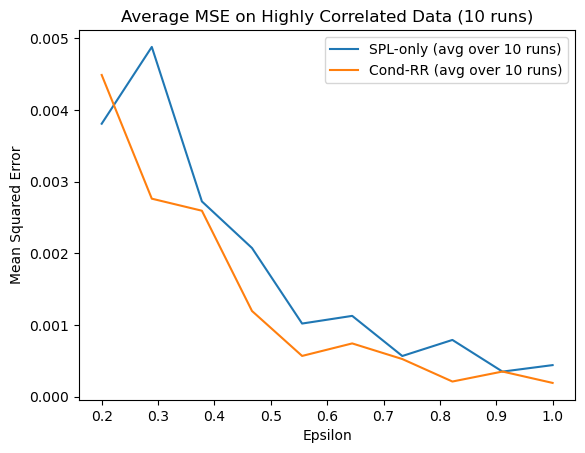

In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Set random seed for reproducibility across runs
np.random.seed(42)

def generate_high_corr_data(n, corr_strength=0.99):
    p_match = corr_strength
    p00 = p_match / 2
    p11 = p_match / 2
    p_mismatch = 1 - p_match
    p01 = p_mismatch / 2
    p10 = p_mismatch / 2
    probs = [p00, p01, p10, p11]
    outcomes = [(0,0), (0,1), (1,0), (1,1)]
    idx = np.random.choice(4, size=n, p=probs)
    return np.array([outcomes[i] for i in idx])

def grr_perturb(bit, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    return bit if np.random.rand() < p else 1 - bit

def rr_estimate(reports, epsilon):
    p = np.exp(epsilon) / (np.exp(epsilon) + 1)
    q = 1 - p
    n = len(reports)
    count1 = np.sum(reports)
    return (count1 - n * q) / (n * (p - q))

def spl_estimate(data, epsilon):
    eps_half = epsilon / 2
    reports = np.array([[grr_perturb(x, eps_half) for x in pair] for pair in data])
    f1 = rr_estimate(reports[:,0], eps_half)
    f2 = rr_estimate(reports[:,1], eps_half)
    return np.array([f1, f2])

def cond_rr_estimate(data, epsilon, m):
    n = len(data)
    eps_half = epsilon / 2

    spl_reports = np.array([[grr_perturb(x, eps_half) for x in pair] for pair in data[:m]])
    counts = {k:0 for k in [(0,0),(0,1),(1,0),(1,1)]}
    for r in spl_reports:
        counts[tuple(r)] += 1
    Y_hat = np.array([counts[k]/m for k in [(0,0),(0,1),(1,0),(1,1)]])
    
    p = np.exp(eps_half) / (np.exp(eps_half) + 1)
    q = 1 - p
    M = np.array([[p*p, p*q, q*p, q*q],
                  [p*q, p*p, q*q, q*p],
                  [q*p, q*q, p*p, p*q],
                  [q*q, q*p, p*q, p*p]])
    P_hat = np.linalg.inv(M).dot(Y_hat)
    P_hat = np.clip(P_hat, 0, None)
    P_hat = P_hat / np.sum(P_hat)
    P00, P01, P10, P11 = P_hat
    cond_2_given_1 = {
        0: P00/(P00+P01) if P00+P01>0 else 0.5,
        1: P10/(P10+P11) if P10+P11>0 else 0.5
    }
    cond_1_given_2 = {
        0: P00/(P00+P10) if P00+P10>0 else 0.5,
        1: P01/(P01+P11) if P01+P11>0 else 0.5
    }

    f1_spl = rr_estimate(spl_reports[:,0], eps_half)
    f2_spl = rr_estimate(spl_reports[:,1], eps_half)

    f_rr_reports = {1: [], 2: []}
    syn_reports = {1: [], 2: []}
    for x1, x2 in data[m:]:
        j = np.random.choice([1,2])
        if j == 1:
            y1 = grr_perturb(x1, epsilon)
            y2 = np.random.choice([0,1], p=[cond_2_given_1[y1], 1-cond_2_given_1[y1]])
            f_rr_reports[1].append(y1)
            syn_reports[2].append(y2)
        else:
            y2 = grr_perturb(x2, epsilon)
            y1 = np.random.choice([0,1], p=[cond_1_given_2[y2], 1-cond_1_given_2[y2]])
            f_rr_reports[2].append(y2)
            syn_reports[1].append(y1)

    est = {}
    for j in [1,2]:
        n_rr = len(f_rr_reports[j])
        n_syn = len(syn_reports[j])
        f_rr_hat = rr_estimate(f_rr_reports[j], epsilon) if n_rr > 0 else 0
        f_syn_hat = np.mean(syn_reports[j]) if n_syn > 0 else 0
        f_spl = f1_spl if j == 1 else f2_spl
        est[j] = (m * f_spl + n_rr * f_rr_hat + n_syn * f_syn_hat) / n

    return np.array([est[1], est[2]])

# Simulation parameters
n = 10000
m = int(0.5 * n)
epsilons = np.linspace(0.2, 1.0, 10)
runs = 10

# Prepare accumulators
mse_spl_acc = np.zeros_like(epsilons)
mse_cond_acc = np.zeros_like(epsilons)

# Run multiple simulations
for run in range(runs):
    data = generate_high_corr_data(n, corr_strength=0.99)
    for i, eps in enumerate(epsilons):
        true_freq = data.mean(axis=0)
        mse_spl_acc[i] += np.mean((spl_estimate(data, eps) - true_freq)**2)
        mse_cond_acc[i] += np.mean((cond_rr_estimate(data, eps, m) - true_freq)**2)

# Compute average MSE
mse_spl_avg = mse_spl_acc / runs
mse_cond_avg = mse_cond_acc / runs

# Plot averaged MSE curves
plt.figure()
plt.plot(epsilons, mse_spl_avg, label='SPL-only (avg over 10 runs)')
plt.plot(epsilons, mse_cond_avg, label='Cond-RR (avg over 10 runs)')
plt.xlabel('Epsilon')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Average MSE on Highly Correlated Data (10 runs)')
plt.show()
